In [28]:

###############################################################################
# EMPIRICAL METHODS IN FINANCE 2025
# =============================================================================
# GROUP MEMBERS:
# Daniel Vito Lobasso
# Thomas Nava
# Jacopo Sinigaglia
# Elvedin Muminovic
# =============================================================================
# Project #2: "Dynamic Allocation and VaR of a Portfolio"
# Goal: Highlight “volatility timing” and compute the Value-at-Risk of portfolio
#       when its return is described as a GARCH model or using extreme value theory.     
###############################################################################

# The code is optimized for Python 3.11.

###############################################################################
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model
from datetime import datetime
from scipy.stats import kstest, norm, t, chi2, jarque_bera, gaussian_kde
from scipy.optimize import minimize
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import lilliefors, acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.distributions.empirical_distribution import ECDF

In [29]:
###############################################################################
# PART 0: DIRECTORY AND DATA SET UP
###############################################################################

# Set working directory to the script's location
base_dir = os.path.dirname(os.path.abspath(sys.argv[0]))
os.chdir(base_dir)
sys.path.insert(0, base_dir)
print("Current working directory:", os.getcwd())
# File paths
input_file = os.path.join("Data", "/Users/jacoposinigaglia/Desktop/svizzera/secondo semestre/empirichal methods in finance/EMF_Project2_Group_5/EMF_Project2_Group_5/Data/DATA_EMF.xlsx")

# LOAD AND PREPARE DATA:
def load_sheet(sheet_name, freq):
    # 1. Load the data from the Excel file
    df = pd.read_excel(input_file, sheet_name=sheet_name, parse_dates=['DATE'])
    
    # 2. Compute simple returns for stocks and bonds
    df['r_s'] = df['SWISS MARKET (SMI) - TOT RETURN IND'].pct_change()
    df['r_b'] = df['SW BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND'].pct_change()
    
    # 3. Compute weekly risk-free rate
    if freq == "weekly":
        df['r_f'] = df['SWISS FRANC S/T DEPO (FT/LSEG DS) - MIDDLE RATE'] / 100 / 52   # annual % -> weekly decimal
    elif freq == "daily":
        df['r_f'] = df['SWISS FRANC S/T DEPO (FT/LSEG DS) - MIDDLE RATE'] / 100 / 261  # annual % -> daily decimal
    
    out = df[['DATE','r_s','r_b','r_f']].dropna().set_index('DATE')
    return out

df_weekly = load_sheet('WEEKLY', 'weekly')
df_daily  = load_sheet('DAILY',  'daily')

print("\n=== Weekly data (head) ===")
print(df_weekly.head())
print("\n=== Daily data (head) ===")
print(df_daily.head())    

Current working directory: /Applications/anaconda3/envs/PRJ_2_EMPIRICAL/lib/python3.12/site-packages

=== Weekly data (head) ===
                 r_s       r_b       r_f
DATE                                    
2001-01-08 -0.018283  0.009610  0.000673
2001-01-15 -0.015562 -0.003818  0.000643
2001-01-22  0.001665 -0.006663  0.000655
2001-01-29  0.020538  0.003522  0.000649
2001-02-05  0.001403  0.008900  0.000649

=== Daily data (head) ===
                 r_s       r_b       r_f
DATE                                    
2001-01-02  0.000000  0.000093  0.000134
2001-01-03 -0.002026  0.006478  0.000134
2001-01-04 -0.000262  0.000683  0.000139
2001-01-05 -0.016158  0.002144  0.000139
2001-01-08  0.000128  0.000189  0.000134


In [30]:
###############################################################################
# PART 1: STATIC ALLOCATION
###############################################################################

df=df_weekly
# Sample means and covariance matrix
mu      = df[['r_s', 'r_b']].mean().values       # vector of sample means
Rf_bar  = df['r_f'].mean()                       # average risk-free rate
Sigma   = df[['r_s', 'r_b']].cov().values        # sample covariance matrix
print("\nSTATIC WEIGHTS INPUTS:")
print("\nsample mean vector")
print(mu)
print("\naverage risk-free rate")
print(Rf_bar)
print("\nsample covariance matrix")
print(Sigma)

# Compute optimal weights for λ = 2 and λ = 10
lambdas = [2, 10]
results = []
for lam in lambdas:
    #  α  =  (Σ⁻¹ (μ - Rf e)) / λ
    alpha = np.linalg.inv(Sigma).dot(mu - Rf_bar * np.ones(2)) / lam
    results.append({
        'lambda': lam,
        'alpha_s': alpha[0],
        'alpha_b': alpha[1],
        'alpha_cash': 1 - alpha.sum()
    })

# Display results
static_weights = pd.DataFrame(results).set_index('lambda')
print("\nOptimal weights for λ = 2 and λ = 10:")
print(static_weights)



STATIC WEIGHTS INPUTS:

sample mean vector
[0.00113717 0.00056756]

average risk-free rate
6.0680680142541166e-05

sample covariance matrix
[[ 6.38677252e-04 -3.30571949e-05]
 [-3.30571949e-05  5.19504012e-05]]

Optimal weights for λ = 2 and λ = 10:
         alpha_s   alpha_b  alpha_cash
lambda                                
2       1.132553  5.599159   -5.731712
10      0.226511  1.119832   -0.346342



= Q2.1: Non-normality & Autocorrelation of excess returns =


= Kolmogorov-Smirnov test on ex_s =

ex_s: K-S p=0.000 (reject N₀)

= Lilliefors test on ex_s =

ex_s: Lilliefors stat = 0.0868, p = 0.0010 (reject normality)
ex_s²: Lilliefors stat = 0.3540, p = 0.0010 (reject normality)


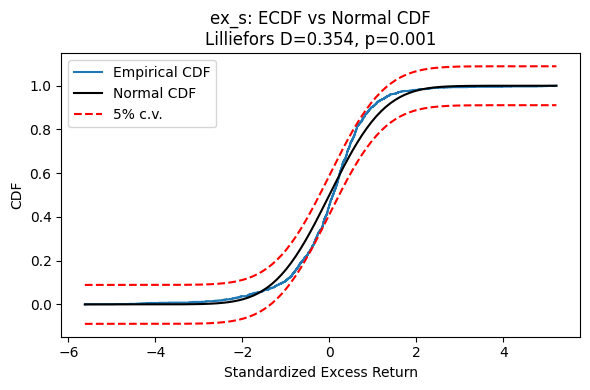

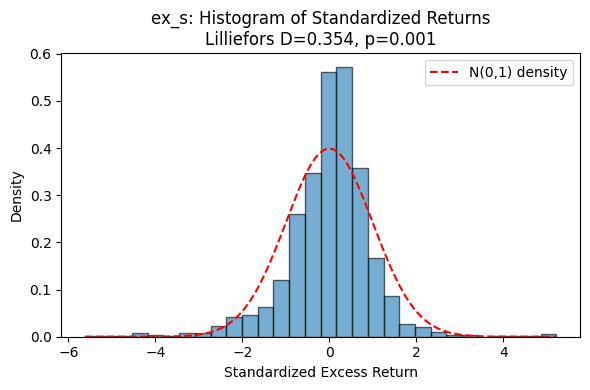


= Ljung-Box for ex_s and ex_s² (portmanteau test) =

  Ljung-Box for ex_s p=[4.40311126e-05 1.83699794e-04 6.28436535e-04 1.72263664e-03] (autocorrelation)
  Ljung-Box for ex_s² p=[8.17795668e-35 3.50688283e-56 8.73331065e-79 2.93417702e-88] (volatility clustering - ARCH effects detected)


= ARCH‐LM Test on ex_s and ex_s² =

  ex_s ARCH‐LM (χ²) stat  = 223.330, p‐value = 0.0000 (reject H0, variance is time‐varying)
  ex_s ARCH‐LM (F‐test) stat = 67.729, p‐value = 0.0000



<Figure size 600x250 with 0 Axes>

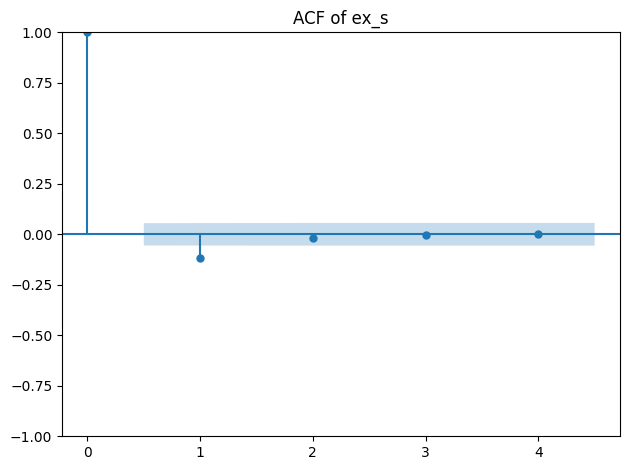

<Figure size 600x250 with 0 Axes>

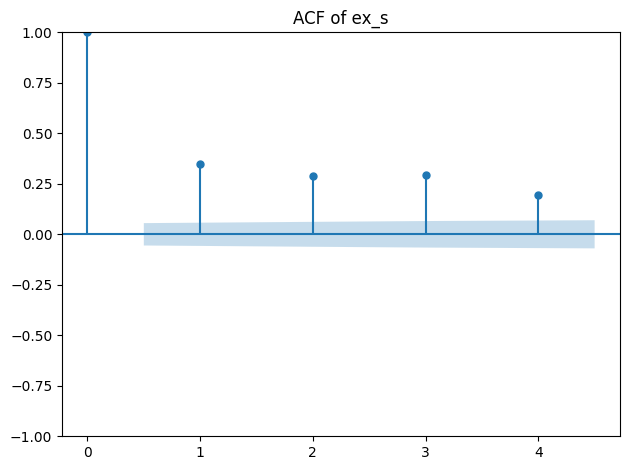


= Kolmogorov-Smirnov test on ex_b =

ex_b: K-S p=0.001 (reject N₀)

= Lilliefors test on ex_b =

ex_b: Lilliefors stat = 0.0571, p = 0.0010 (reject normality)
ex_b²: Lilliefors stat = 0.3567, p = 0.0010 (reject normality)


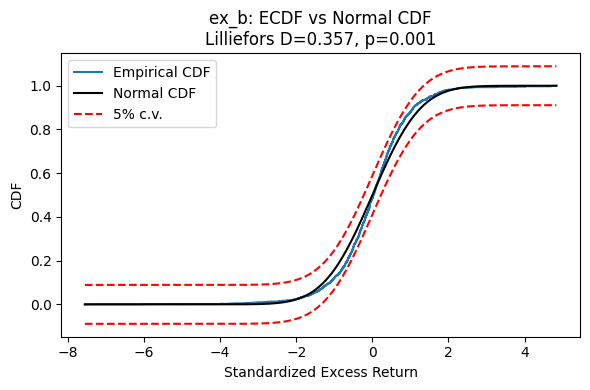

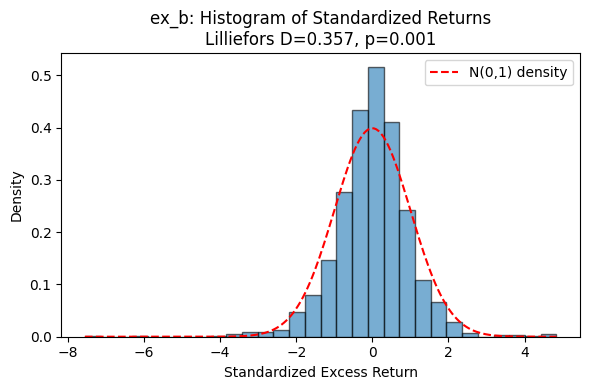


= Ljung-Box for ex_b and ex_b² (portmanteau test) =

  Ljung-Box for ex_b p=[0.36045215 0.43874149 0.51011328 0.65451865] (no autocorrelation)
  Ljung-Box for ex_b² p=[3.25374172e-11 3.97052214e-14 5.48301599e-15 1.14390621e-15] (volatility clustering - ARCH effects detected)


= ARCH‐LM Test on ex_b and ex_b² =

  ex_b ARCH‐LM (χ²) stat  = 57.458, p‐value = 0.0000 (reject H0, variance is time‐varying)
  ex_b ARCH‐LM (F‐test) stat = 14.997, p‐value = 0.0000



<Figure size 600x250 with 0 Axes>

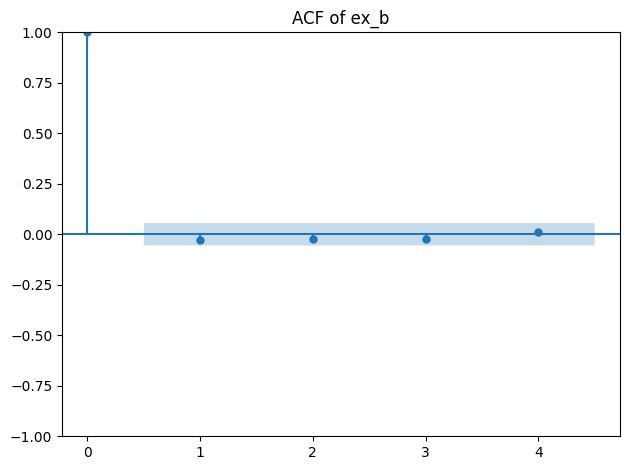

<Figure size 600x250 with 0 Axes>

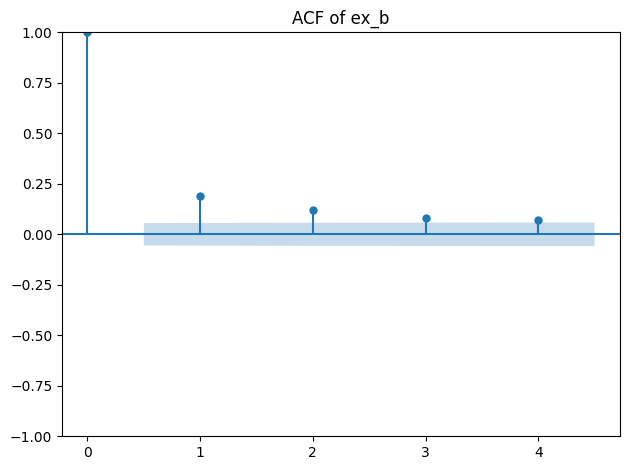

In [31]:
###############################################################################
# PART 2: ESTIMATION OF A GARCH MODEL
###############################################################################

# -----------------------------------------------------------------------------
# Q2.1: Non-normality (Lilliefors and K-S) and autocorrelation (Ljung-Box) on excess returns
# -----------------------------------------------------------------------------
df['ex_s'] = df['r_s'] - df['r_f']      # excess return stock
df['ex_b'] = df['r_b'] - df['r_f']      # excess return bond

print("\n= Q2.1: Non-normality & Autocorrelation of excess returns =\n")
for name in ['ex_s','ex_b']:
    x = df[name].dropna()
    
    print(f"\n= Kolmogorov-Smirnov test on {name} =\n")
    # Kolmogorov-Smirnov vs. N(0,1)
    z = (x - x.mean())/x.std(ddof=0)
    ks_stat, ks_p = kstest(z, 'norm')
    print(f"{name}: K-S p={ks_p:.3f} {'(reject N₀)' if ks_p<0.05 else '(no rej)'}")
    
    print(f"\n= Lilliefors test on {name} =\n")
    # Lilliefors test for Normal(μ,σ²)
    stat, pval = lilliefors(x, dist='norm')
    print(f"{name}: Lilliefors stat = {stat:.4f}, p = {pval:.4f}", 
          "(reject normality)" if pval < 0.05 else "(no rejection)")
    stat, pval = lilliefors(x**2, dist='norm')
    print(f"{name}²: Lilliefors stat = {stat:.4f}, p = {pval:.4f}", 
          "(reject normality)" if pval < 0.05 else "(no rejection)")
    
    
    # Approximate 5% Lilliefors critical value (large-n ≈0.089)
    c05 = 0.089
    # ECDF vs Normal CDF + Lilliefors band
    ecdf = ECDF(z)
    xs = np.linspace(z.min(), z.max(), 200)
    phi = norm.cdf(xs)
    plt.figure(figsize=(6,4))
    plt.step(ecdf.x, ecdf.y, where='post', label='Empirical CDF')
    plt.plot(xs, phi, 'k-', label='Normal CDF')
    plt.plot(xs, phi + c05, 'r--', label='5% c.v.') # label=f'±{c05:.3f} Lilliefors band'
    plt.plot(xs, phi - c05, 'r--')
    plt.title(f"{name}: ECDF vs Normal CDF\nLilliefors D={stat:.3f}, p={pval:.3f}")
    plt.xlabel('Standardized Excess Return')
    plt.ylabel('CDF')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Histogram vs Normal density
    plt.figure(figsize=(6,4))
    plt.hist(z, bins=30, density=True, alpha=0.6, edgecolor='black')
    xs2 = np.linspace(z.min(), z.max(), 200)
    plt.plot(xs2, norm.pdf(xs2), 'r--', label='N(0,1) density')
    plt.title(f"{name}: Histogram of Standardized Returns\nLilliefors D={stat:.3f}, p={pval:.3f}")
    plt.xlabel('Standardized Excess Return')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\n= Ljung-Box for {name} and {name}² (portmanteau test) =\n")
    # Ljung-Box on returns and squared returns (4 lags)
    lb_ret = acorr_ljungbox(x, lags=4, return_df=True)['lb_pvalue']
    lb_sq  = acorr_ljungbox(x**2, lags=4, return_df=True)['lb_pvalue']
    print(f"  Ljung-Box for {name} p={lb_ret.values} {'(autocorrelation)' if (lb_ret<0.05).any() else '(no autocorrelation)'}")
    print(f"  Ljung-Box for {name}² p={lb_sq.values} {'(volatility clustering - ARCH effects detected)' if (lb_sq<0.05).any() else '(no volatility clustering - no ARCH effects)'}\n")
    
    # equivalent to Ljung-Box on squared returns:
    print(f"\n= ARCH‐LM Test on {name} and {name}² =\n")
    # Test for ARCH effects in the residuals up to lag 4
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(x, nlags=4)
    print(f"  {name} ARCH‐LM (χ²) stat  = {lm_stat:.3f}, p‐value = {lm_pvalue:.4f}", 
          "(reject H0, variance is time‐varying)" if lm_pvalue < 0.05 else "(FAIL to reject H0, no ARCH detected, residuals’ variance is constant)")
    print(f"  {name} ARCH‐LM (F‐test) stat = {f_stat:.3f}, p‐value = {f_pvalue:.4f}\n")
    # H₀: No ARCH effects (i.e. residuals’ variance is constant).
    # H₁: ARCH effects present (variance is time‐varying).
    
    # ACF of returns
    plt.figure(figsize=(6,2.5))
    plot_acf(x, lags=4, title=f"ACF of {name}")
    plt.tight_layout()
    plt.show()
    
    # ACF of squared returns
    plt.figure(figsize=(6,2.5))
    plot_acf(x**2, lags=4, title=f"ACF of {name}")
    plt.tight_layout()
    plt.show()

In [32]:
# -----------------------------------------------------------------------------
# Q2.2: AR(1) on simple returns (Rs,t and Rb,t), extract residuals
# -----------------------------------------------------------------------------
print("\n=== Q2.2: AR(1) on Simple Returns ===\n")
ar1_res = {}
residuals = {}
for name in ['r_s','r_b']:
    y = df[name].dropna()
    X = sm.add_constant(y.shift(1)).dropna()
    y_aligned = y.loc[X.index]
    ar1 = sm.OLS(y_aligned, X).fit()
    ar1_res[name] = ar1
    print(f"{name} AR(1) results:\n", ar1.summary(), "\n")
    residuals[name] = ar1.resid
    
    # Test for ARCH effects in the residuals up to lag 4
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(ar1.resid, nlags=4)
    print(f"  ARCH‐LM (χ²) stat  = {lm_stat:.3f}, p‐value = {lm_pvalue:.4f}", 
          "(reject H0, variance is time‐varying)" if lm_pvalue < 0.05 else "(FAIL to reject H0, no ARCH detected, residuals’ variance is constant)")
    print(f"  ARCH‐LM (F‐test) stat = {f_stat:.3f}, p‐value = {f_pvalue:.4f}\n")
    # H₀: No ARCH effects (i.e. residuals’ variance is constant).
    # H₁: ARCH effects present (variance is time‐varying).


=== Q2.2: AR(1) on Simple Returns ===

r_s AR(1) results:
                             OLS Regression Results                            
Dep. Variable:                    r_s   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     17.20
Date:                Thu, 15 May 2025   Prob (F-statistic):           3.60e-05
Time:                        13:41:44   Log-Likelihood:                 2835.0
No. Observations:                1251   AIC:                            -5666.
Df Residuals:                    1249   BIC:                            -5656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [33]:
# -----------------------------------------------------------------------------
# Q2.3: GARCH(1,1) on AR(1) residuals via MLE (arch_model)
# -----------------------------------------------------------------------------

# BOOTSTRAP NON E' RICHIESTO DAL PROF #
def bootstrap_test(eps, name, B=500, scale=100, garch_res=None):
    """
    Perform LR bootstrap test for H0: alpha + beta = 1 with rescaled residuals,
    store results, and print the unconstrained GARCH summary.

    Parameters:
    -----------
    eps : np.ndarray
        AR(1) residuals (raw, unscaled).
    name : str
        Label for storing results (e.g., 'r_s', 'r_b').
    B : int
        Number of bootstrap replications.
    target_std_range : tuple
        Desired standard deviation range for rescaling.
    garch_res : dict
        Dictionary to store GARCH results.

    Returns:
    --------
    Updated garch_res dictionary with fitted models and bootstrap test results.
    """

    # Rescale residuals for numerical stability
    scale_factor = scale
    eps_scaled =  eps*scale_factor
    T = len(eps_scaled)
    
    if garch_res is None:
        garch_res = {}
    garch_res[name] = {}

    # Unconstrained estimation
    model_uncon = arch_model(eps_scaled, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
    res_uncon = model_uncon.fit(disp='off', cov_type='classic')
    loglik_uncon = res_uncon.loglikelihood

    print(f"\n--- {name} Unrestricted GARCH(1,1) Model Summary ---")
    print(res_uncon.summary())
    garch_res[name]['unrestricted'] = res_uncon

    # Constrained log-likelihood
    def constrained_loglik(params, data):
        omega, alpha = params
        beta = 1 - alpha
        if omega <= 0 or alpha < 0 or beta < 0 or alpha > 1 or beta > 1:
            return 1e6
        sigma2 = np.ones(len(data)) * np.var(data)
        for t in range(1, len(data)):
            sigma2[t] = omega + alpha * data[t - 1] ** 2 + beta * sigma2[t - 1]
        return -(-0.5 * np.sum(np.log(2 * np.pi) + np.log(sigma2) + data ** 2 / sigma2))

    # Estimate constrained model
    start_vals = [res_uncon.params['omega'], res_uncon.params['alpha[1]']]
    res_constr = minimize(constrained_loglik, start_vals, args=(eps_scaled,), method='L-BFGS-B')
    omega_c, alpha_c = res_constr.x
    loglik_constr = -res_constr.fun
    LR_obs = 2 * (loglik_uncon - loglik_constr)
    p_asymptotic = 1 - chi2.cdf(LR_obs, df=1)

    garch_res[name]['constrained'] = res_constr
    
    print(f" {name} Unrestricted GARCH MLE estimates under H1 (alpha + beta < 1):")
    ω, α, β = res_uncon.params[['omega','alpha[1]','beta[1]']]
    print(f" ω={ω:.6f}, α={α:.6f}, β={β:.6f}, α+β={(α+β):.4f}")
    
    beta_c = 1 - alpha_c  # since beta is implied by the constraint
    print(f" {name} Constrained GARCH MLE estimates under H0 (alpha + beta = 1):")
    print(f" ω={omega_c:.6f}, α={alpha_c:.6f}, β={beta_c:.6f}, α+β={(alpha_c+beta_c):.4f}")

    # Bootstrap DGP
    def simulate_series(omega, alpha, T, var_data):
        beta = 1 - alpha
        eps_sim = np.zeros(T)
        sigma2 = np.ones(T) * var_data
        for t in range(1, T):
            sigma2[t] = omega + alpha * eps_sim[t - 1]**2 + beta * sigma2[t - 1]
            eps_sim[t] = np.sqrt(sigma2[t]) * np.random.normal()
        return eps_sim

    # Bootstrap loop
    bootstrap_LRs = []
    for _ in range(B):
        eps_b = simulate_series(omega_c, alpha_c, T, np.var(eps_scaled))
        try:
            model_b = arch_model(eps_b, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
            res_uncon_b = model_b.fit(disp='off')
            loglik_uncon_b = res_uncon_b.loglikelihood
            res_constr_b = minimize(constrained_loglik, start_vals, args=(eps_b,), method='L-BFGS-B')
            loglik_constr_b = -res_constr_b.fun
            LR_b = 2 * (loglik_uncon_b - loglik_constr_b)
            bootstrap_LRs.append(LR_b)
        except:
            continue

    p_bootstrap = np.mean(np.array(bootstrap_LRs) >= LR_obs)

    # Store test results
    garch_res[name]['bootstrap_test'] = {
        "scale factor": scale_factor,
        "LR observed": LR_obs,
        "p-asymptotic (χ²₁)": p_asymptotic,
        "p-bootstrap": p_bootstrap,
        "bootstrap iterations": B
        
    }

    return garch_res

#eps = residuals['r_s'].values
#garch_res = bootstrap_test(eps, name='SMI', B=500, scale=100)
#results = garch_res['SMI']['bootstrap_test']
#print("\n--- Bootstrap LR Test Results for H₀: α + β = 1 ---")
#print(f"{'Scale factor:':<30} {results['scale factor']}")
#print(f"{'Observed LR statistic:':<30} {results['LR observed']:.4f}")
#print(f"{'Asymptotic p-value (χ²₁):':<30} {results['p-asymptotic (χ²₁)']:.4f}")
#print(f"{'Bootstrap p-value:':<30} {results['p-bootstrap']:.4f}")
#print(f"{'Bootstrap replications:':<30} {results['bootstrap iterations']}")

#eps = residuals['r_b'].values
#garch_res = bootstrap_test(eps, name='SWISS GOVT. BONDS', B=500, scale=100, garch_res=garch_res)
#results = garch_res['SWISS GOVT. BONDS']['bootstrap_test']
#print("\n--- Bootstrap LR Test Results for H₀: α + β = 1 ---")
#print(f"{'Scale factor:':<30} {results['scale factor']}")
#print(f"{'Observed LR statistic:':<30} {results['LR observed']:.4f}")
#print(f"{'Asymptotic p-value (χ²₁):':<30} {results['p-asymptotic (χ²₁)']:.4f}")
#print(f"{'Bootstrap p-value:':<30} {results['p-bootstrap']:.4f}")
#print(f"{'Bootstrap replications:':<30} {results['bootstrap iterations']}")


print("\n=== Q2.3: GARCH(1,1) on AR(1) Residuals ===\n")
garch_res = {}
for name, eps in residuals.items():
    print(f"--- {name} GARCH(1,1) ---")
    model = arch_model(eps, mean='Zero', vol='GARCH', p=1, q=1, dist='normal', rescale=True)
    # print iteration info every iter, allow up to 1000 its
    res = model.fit(cov_type='classic', update_freq=10, disp='on', options={'maxiter':1000}) #cov_type='robust'
    garch_res[name] = res
    ω, α, β = res.params[['omega','alpha[1]','beta[1]']]
    print(res.summary())
    
    # Extract the scale factor c
    c = res.scale
    print(f"Applied scale factor: {c:.0f}\n")
    
    omega_unscaled = ω / (c**2)              # GARCH constant

    # Print un-scaled results
    print("\nUn-scaled (original data units):")
    print(f" ω={omega_unscaled:.6f}, α={α:.6f}, β={β:.6f}, α+β={(α+β):.4f}")
    
    #print("\nGARCH Model Results:")
    #print(f"ω={ω:.6f}, α={α:.6f}, β={β:.6f}, α+β={(α+β):.4f}")

    # Wald test H0: α+β = 1 vs H1: α+β < 1 (one‐sided)
    #    a) Compute difference and its variance via delta method
    d = (α + β) - 1.0
    cov_ab = res.param_cov.loc[['alpha[1]','beta[1]'],
                               ['alpha[1]','beta[1]']]
    var_d = (
    cov_ab.loc['alpha[1]','alpha[1]']
    + cov_ab.loc['beta[1]','beta[1]']
    + 2*cov_ab.loc['alpha[1]','beta[1]']
    )
    #    b) z‐statistic and one‐sided p‐value
    z_stat    = d / np.sqrt(var_d)
    p_one_sided = norm.cdf(z_stat)   # P(Z ≤ z_stat) for H1: α+β < 1
    print("\nWald test of H0: α+β = 1  vs  H1: α+β < 1")
    print(f" z = {z_stat:.4f}, one‐sided p‐value = {p_one_sided:.4f}\n")



=== Q2.3: GARCH(1,1) on AR(1) Residuals ===

--- r_s GARCH(1,1) ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2740.50
Distribution:                  Normal   AIC:                           5487.00
Method:            Maximum Likelihood   BIC:                           5502.40
                                        No. Observations:                 1251
Date:                Thu, May 15 2025   Df Residuals:                     1251
Time:                        13:41:44   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
o


=== Q2.3: AR(1)-GARCH(1,1) ===

--- r_s GARCH(1,1) ---
Applied scale factor: 100

                           AR - GARCH Model Results                           
Dep. Variable:                    r_s   R-squared:                       0.005
Mean Model:                        AR   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -2734.69
Distribution:                  Normal   AIC:                           5479.38
Method:            Maximum Likelihood   BIC:                           5505.04
                                        No. Observations:                 1251
Date:                Thu, May 15 2025   Df Residuals:                     1249
Time:                        13:41:45   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------

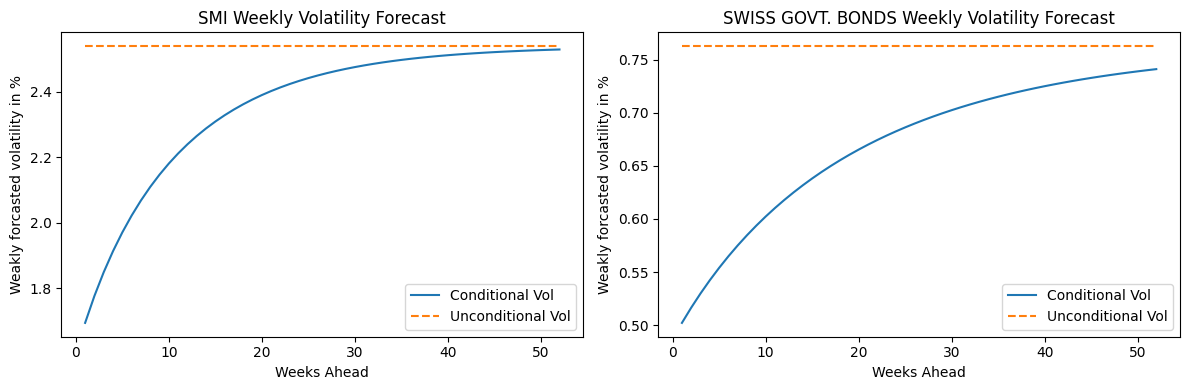

In [34]:
# FATTO IN PIU' PER VEDERE COME CAMBIANO PARAMETRI #
print("\n=== Q2.3: AR(1)-GARCH(1,1) ===\n")
#garch_res = {}
for name in ['r_s','r_b']:
    print(f"--- {name} GARCH(1,1) ---")
    model = arch_model(df[name], mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal', rescale=True)
    # print iteration info every iter, allow up to 1000 its
    res = model.fit(cov_type='classic', update_freq=10, disp='off', options={'maxiter':1000}) # cov_type='robust'
    #garch_res[name] = res
    
    # Extract the scale factor c
    c = res.scale
    print(f"Applied scale factor: {c:.0f}\n")
    
    ω, α, β = res.params[['omega','alpha[1]','beta[1]']]
    print(res.summary())
    
    mu_unscaled  = res.params['Const'] / c   # AR intercept
    omega_unscaled = ω / (c**2)              # GARCH constant

    # Print un-scaled results
    print("\nUn-scaled (original data units):")
    print(f" AR(1): const={mu_unscaled:.6f}, φ={res.params[f'{name}[1]']:.6f}")
    print(f" ω={omega_unscaled:.6f}, α={α:.6f}, β={β:.6f}, α+β={(α+β):.4f}")
    
    #print("\nAR - GARCH Model Results:")
    #print(f" AR(1): const={res.params['Const']:.6f}, φ={res.params[f'{name}[1]']:.6f}")
    #print(f" GARCH(1,1): ω={ω:.6f}, α={α:.6f}, β={β:.6f}, α+β={(α+β):.4f}")
    
    # Wald test H0: α+β = 1 vs H1: α+β < 1 (one‐sided)
    #    a) Compute difference and its variance via delta method
    d = (α + β) - 1.0
    cov_ab = res.param_cov.loc[['alpha[1]','beta[1]'],
                               ['alpha[1]','beta[1]']]
    var_d = (
    cov_ab.loc['alpha[1]','alpha[1]']
    + cov_ab.loc['beta[1]','beta[1]']
    + 2*cov_ab.loc['alpha[1]','beta[1]']
    )
    #    b) z‐statistic and one‐sided p‐value
    z_stat    = d / np.sqrt(var_d)
    p_one_sided = norm.cdf(z_stat)   # P(Z ≤ z_stat) for H1: α+β < 1
    print("\nWald test of H0: α+β = 1  vs  H1: α+β < 1")
    print(f" z = {z_stat:.4f}, one‐sided p‐value = {p_one_sided:.4f}\n")

# ----------------------------------------------------------------------------
# Wald test H0: α+β = 1 vs H1: α+β < 1 (one‐sided)
# Prof told me it is good as it is done here.
# TA: The constraint enforced by the arch package might affect the validity 
#     of the Wald test, since the boundary is excluded during the estimation.
# ----------------------------------------------------------------------------

garch_res['SMI'] = garch_res['r_s']
garch_res['SWISS GOVT. BONDS'] = garch_res['r_b']

# Volatility forecast (52 weeks)
horizon = 52
# 1) Unconditional variances
uc_s = ((garch_res['SMI'].params['omega'])/garch_res['SMI'].scale**2) / (1 - garch_res['SMI'].params['alpha[1]'] - garch_res['SMI'].params['beta[1]'])
uc_b = ((garch_res['SWISS GOVT. BONDS'].params['omega'])/garch_res['SWISS GOVT. BONDS'].scale**2) / (1 - garch_res['SWISS GOVT. BONDS'].params['alpha[1]'] - garch_res['SWISS GOVT. BONDS'].params['beta[1]'])
# 2) Conditional variance forecasts for next 52 weeks
vf_s = garch_res['SMI'].forecast(horizon=horizon, reindex=False).variance.iloc[0].values/garch_res['SMI'].scale**2
vf_b = garch_res['SWISS GOVT. BONDS'].forecast(horizon=horizon, reindex=False).variance.iloc[0].values/garch_res['SWISS GOVT. BONDS'].scale**2
# 3) Plotting
weeks = np.arange(1, horizon+1)
plt.figure(figsize=(12, 4))
# Stock volatility forecast
plt.subplot(1, 2, 1)
plt.plot(weeks, np.sqrt(vf_s) * 100, label='Conditional Vol')
plt.plot(weeks, np.sqrt(uc_s) * 100 * np.ones(horizon), '--', label='Unconditional Vol')
plt.title('SMI Weekly Volatility Forecast')
plt.xlabel('Weeks Ahead')
plt.ylabel('Weakly forcasted volatility in %')
plt.legend()
# Bond volatility forecast
plt.subplot(1, 2, 2)
plt.plot(weeks, np.sqrt(vf_b) * 100, label='Conditional Vol')
plt.plot(weeks, np.sqrt(uc_b) * 100 * np.ones(horizon), '--', label='Unconditional Vol')
plt.title('SWISS GOVT. BONDS Weekly Volatility Forecast')
plt.xlabel('Weeks Ahead')
plt.ylabel('Weakly forcasted volatility in %')
plt.legend()
plt.tight_layout()
plt.show()

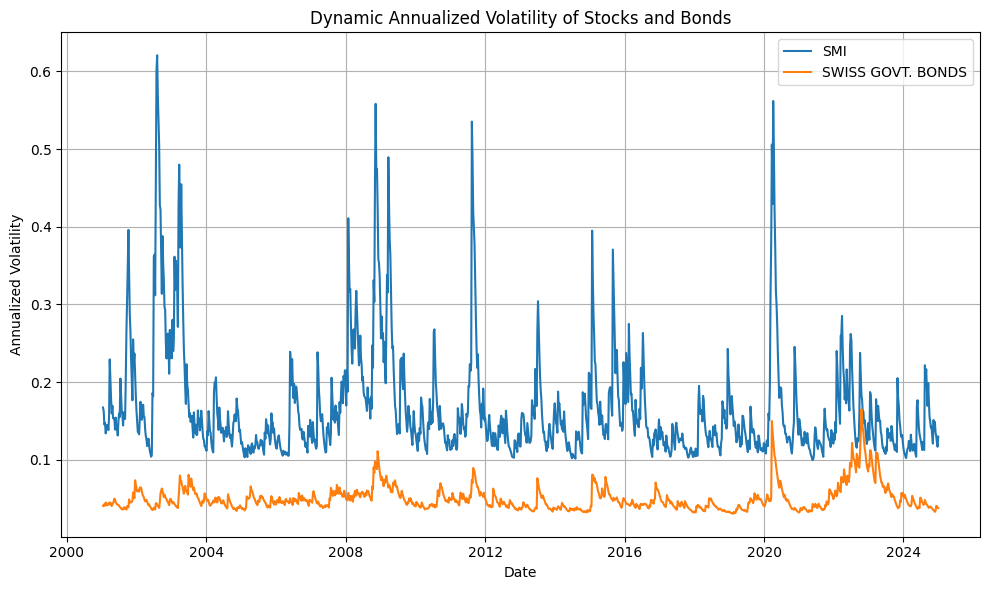

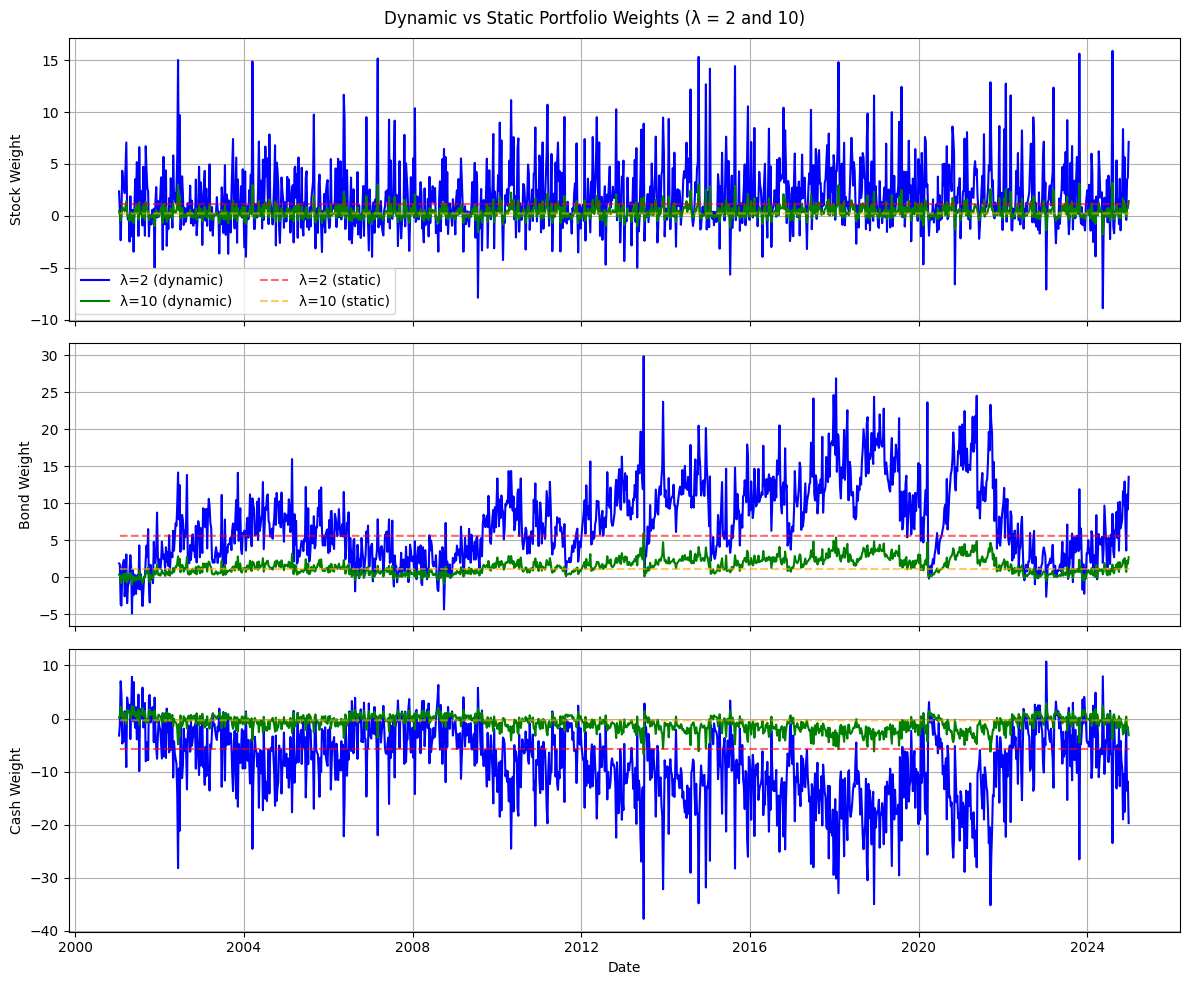

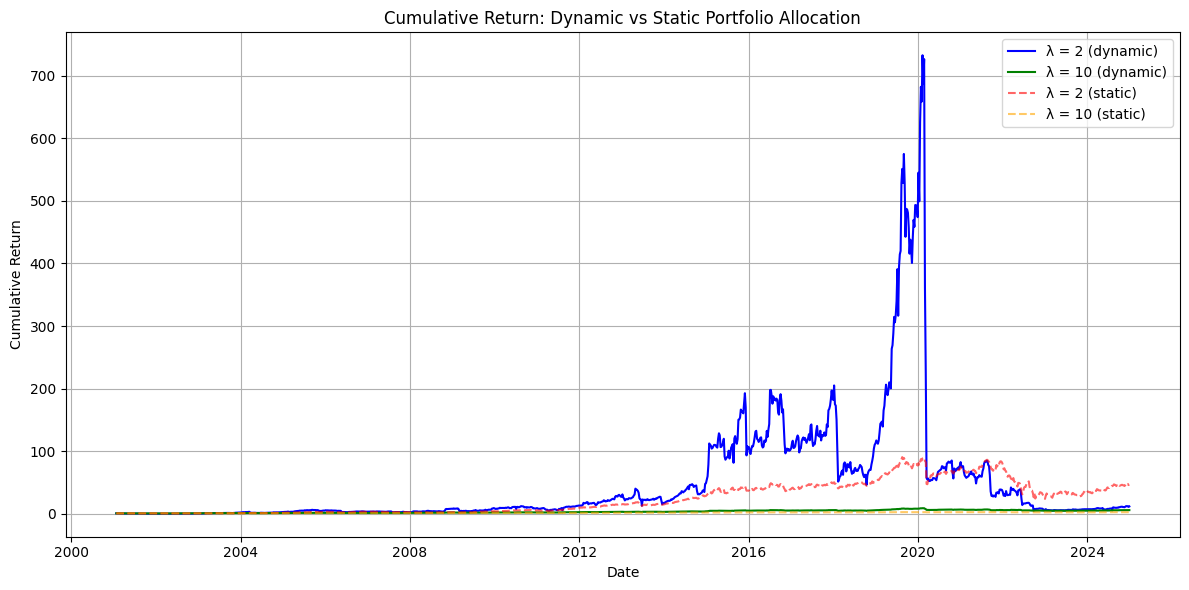

Break-even transaction cost rate for λ = 2: f = 0.0000%
Break-even transaction cost rate for λ = 10: f = 0.0540%


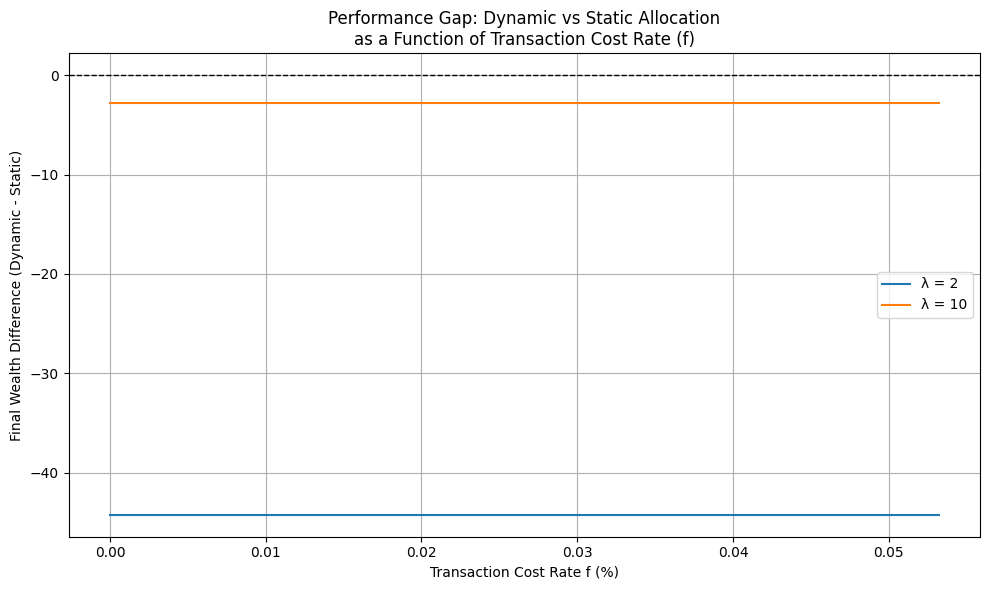

In [35]:
###############################################################################
# PART 3: DYNAMIC ALLOCATION
###############################################################################

# --- 1. STATIC WEIGHTS (for comparison) ---
mu = df[['r_s', 'r_b']].mean().values
Rf_bar = df['r_f'].mean()
Sigma = df[['r_s', 'r_b']].cov().values

static_weights = {}
for lam in [2, 10]:
    alpha = np.linalg.inv(Sigma).dot(mu - Rf_bar * np.ones(2)) / lam
    static_weights[lam] = {
        'alpha_s': alpha[0],
        'alpha_b': alpha[1],
        'alpha_cash': 1 - alpha.sum()
    }

# --- 2. AR(1) FORECASTS AND GARCH CONDITIONAL VARIANCE ---
# Forecast means μ_{t+1|t} using AR(1)
a_s, rho_s = ar1_res['r_s'].params
a_b, rho_b = ar1_res['r_b'].params

mu_s = a_s + rho_s * df['r_s'].shift(1)
mu_b = a_b + rho_b * df['r_b'].shift(1)

# Residual correlation (assumed constant)
eps_s = ar1_res['r_s'].resid        # SMI AR(1) params
eps_b = ar1_res['r_b'].resid        # SWISS GOVT. BONDS AR(1) params
rho_sb = eps_s.corr(eps_b)

index_s = eps_s.dropna().index
index_b = eps_b.dropna().index

# GARCH conditional variance (1-step ahead forecast)
cond_s = pd.Series(
    garch_res['SMI'].conditional_volatility**2 / garch_res['SMI'].scale**2,
    index=index_s
)
cond_b = pd.Series(
    garch_res['SWISS GOVT. BONDS'].conditional_volatility**2 / garch_res['SWISS GOVT. BONDS'].scale**2,
    index=index_b
)
sigma2_s = cond_s.shift(1)
sigma2_b = cond_b.shift(1)
sigma_sb = rho_sb * np.sqrt(sigma2_s) * np.sqrt(sigma2_b)

df_forecast = pd.concat([
    mu_s, mu_b, sigma2_s, sigma2_b, sigma_sb, df['r_f']
], axis=1, keys=['mu_s', 'mu_b', 'sigma2_s', 'sigma2_b', 'sigma_sb', 'r_f']).dropna()


# PLOT DYNAMIC ANNUALIZED VOLATILITY #
# Annualize (weekly vol × sqrt(52))
#vol_stock_ann = garch_res['SMI'].conditional_volatility / garch_res['SMI'].scale  * np.sqrt(52)
#vol_bond_ann = garch_res['SWISS GOVT. BONDS'].conditional_volatility / garch_res['SWISS GOVT. BONDS'].scale * np.sqrt(52)
vol_stock_ann = np.sqrt(cond_s) * np.sqrt(52)
vol_bond_ann = np.sqrt(cond_b)  * np.sqrt(52)
# Create DataFrame
vol_df = pd.DataFrame({
    'Stock (SMI)': vol_stock_ann,
    'Bond (Swiss Gov)': vol_bond_ann
})
# Plot
plt.figure(figsize=(10, 6))
plt.plot(vol_df.index, vol_df['Stock (SMI)'], label='SMI')
plt.plot(vol_df.index, vol_df['Bond (Swiss Gov)'], label='SWISS GOVT. BONDS')
plt.title('Dynamic Annualized Volatility of Stocks and Bonds')
plt.ylabel('Annualized Volatility')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- DYNAMIC WEIGHTS COMPUTATION ---
alphas_dyn = {}
for lam in [2, 10]:
    weights = []
    for t in df_forecast.index:
        μ = df_forecast.loc[t, ['mu_s', 'mu_b']].values
        Σ = np.array([[df_forecast.loc[t, 'sigma2_s'], df_forecast.loc[t, 'sigma_sb']],
                      [df_forecast.loc[t, 'sigma_sb'], df_forecast.loc[t, 'sigma2_b']]])
        rf = df_forecast.loc[t, 'r_f']
        alpha = np.linalg.inv(Σ).dot(μ - rf * np.ones(2)) / lam
        weights.append(alpha)
    alphas_dyn[lam] = pd.DataFrame(weights, columns=['alpha_s', 'alpha_b'], index=df_forecast.index)
    alphas_dyn[lam]['alpha_cash'] = 1 - alphas_dyn[lam].sum(axis=1)

# Create static weight time series
static_df = {}
for lam in [2, 10]:
    w = static_weights[lam]
    static_df[lam] = pd.DataFrame({
        'alpha_s': [w['alpha_s']] * len(df_forecast),
        'alpha_b': [w['alpha_b']] * len(df_forecast),
        'alpha_cash': [w['alpha_cash']] * len(df_forecast)
    }, index=df_forecast.index)


# --- CUMULATIVE RETURNS ---
CR, static_CR = {}, {}
for lam in [2, 10]:
    w_dyn = alphas_dyn[lam]
    Rf_dyn = df.loc[w_dyn.index, 'r_f']
    Rs = df.loc[w_dyn.index, 'r_s']
    Rb = df.loc[w_dyn.index, 'r_b']
    Rp_dyn = w_dyn['alpha_s'] * Rs + w_dyn['alpha_b'] * Rb + w_dyn['alpha_cash'] * Rf_dyn
    CR[lam] = np.exp(np.log(1 + Rp_dyn).cumsum())

    w_stat = static_weights[lam]
    Rp_stat = w_stat['alpha_s'] * Rs + w_stat['alpha_b'] * Rb + w_stat['alpha_cash'] * Rf_dyn
    static_CR[lam] = np.exp(np.log(1 + Rp_stat).cumsum())

# --- PLOT WEIGHTS ---
alphas_dyn[2].index = alphas_dyn[lam].index - pd.Timedelta(weeks=1)
alphas_dyn[10].index = alphas_dyn[lam].index - pd.Timedelta(weeks=1)
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
labels = ['Stock Weight', 'Bond Weight', 'Cash Weight']
for i, name in enumerate(['alpha_s', 'alpha_b', 'alpha_cash']):
    axs[i].plot(alphas_dyn[2].index, alphas_dyn[2][name], label='λ=2 (dynamic)', color='blue')
    axs[i].plot(alphas_dyn[10].index, alphas_dyn[10][name], label='λ=10 (dynamic)', color='green')
    axs[i].plot(static_df[2].index, static_df[2][name], '--', label='λ=2 (static)', color='red', alpha=0.6)
    axs[i].plot(static_df[10].index, static_df[10][name], '--', label='λ=10 (static)', color='orange', alpha=0.6)
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
axs[2].set_xlabel("Date")
axs[0].legend(ncol=2)
fig.suptitle("Dynamic vs Static Portfolio Weights (λ = 2 and 10)")
plt.tight_layout()
plt.show()

# --- PLOT CUMULATIVE RETURNS ---
plt.figure(figsize=(12, 6))
plt.plot(CR[2], label='λ = 2 (dynamic)', color='blue')
plt.plot(CR[10], label='λ = 10 (dynamic)', color='green')
plt.plot(static_CR[2], '--', label='λ = 2 (static)', color='red', alpha=0.6)
plt.plot(static_CR[10], '--', label='λ = 10 (static)', color='orange', alpha=0.6)
plt.title('Cumulative Return: Dynamic vs Static Portfolio Allocation')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- TRANSACTION COSTS ---
def compute_transaction_costs(weights_df, f):
    """
    Compute transaction costs based on absolute weight changes times fee f.
    The cash weight is ignored (no cost for risk-free asset).
    """
    delta_s = weights_df['alpha_s'].diff().abs()
    delta_b = weights_df['alpha_b'].diff().abs()
    TC = (delta_s + delta_b) * f
    return TC.fillna(0)

# Construct transaction cost range
f_values = np.linspace(0, 0.10, 10000)  # from 0% to 10%
break_even_f = {}

for lam in [2, 10]:
    # Shift index if not already corrected
    weights = alphas_dyn[lam]
    Rs = df['r_s'].shift(-1).loc[weights.index]
    Rb = df['r_b'].shift(-1).loc[weights.index]
    Rf_dyn = df['r_f'].shift(-1).loc[weights.index]

    # Dynamic portfolio return
    Rp_dyn = weights['alpha_s'] * Rs + weights['alpha_b'] * Rb + weights['alpha_cash'] * Rf_dyn

    # Static portfolio return
    w_stat = static_weights[lam]
    Rp_stat = w_stat['alpha_s'] * Rs + w_stat['alpha_b'] * Rb + w_stat['alpha_cash'] * Rf_dyn

    # Search for the f that equalizes cumulative returns
    for f in f_values:
        TC = compute_transaction_costs(weights, f)
        Rp_dyn_net = Rp_dyn - TC

        # Use log returns if explosive
        cum_log_dyn = np.log1p(Rp_dyn_net).cumsum()
        cum_log_stat = np.log1p(Rp_stat).cumsum()

        # Compare final wealth
        if np.exp(cum_log_dyn.iloc[-1]) <= np.exp(cum_log_stat.iloc[-1]):
            break_even_f[lam] = f
            break

# --- DISPLAY RESULTS ---
for lam in [2, 10]:
    print(f"Break-even transaction cost rate for λ = {lam}: f = {break_even_f[lam]:.4%}")



# We want to compare the performance gap vs transaction cost f
f_values = np.linspace(0, 0.000532, 100)  # from 0% to 10%
# Store final cumulative wealths for each f and lambda
final_wealth_dyn = {2: [], 10: []}
final_wealth_stat = {}

for lam in [2, 10]:
    # Get weights and returns
    weights = alphas_dyn[lam].copy()
    weights.index = weights.index - pd.Timedelta(weeks=1)  # align to decision date

    Rs = df['r_s'].shift(-1).loc[weights.index]
    Rb = df['r_b'].shift(-1).loc[weights.index]
    Rf_dyn = df['r_f'].shift(-1).loc[weights.index]

    # Dynamic return pre-cost
    Rp_dyn = weights['alpha_s'] * Rs + weights['alpha_b'] * Rb + weights['alpha_cash'] * Rf_dyn

    # Static return
    w_stat = static_weights[lam]
    Rp_stat = w_stat['alpha_s'] * Rs + w_stat['alpha_b'] * Rb + w_stat['alpha_cash'] * Rf_dyn
    rp_stat = np.log1p(Rp_stat)
    final_wealth_stat[lam] = np.exp(rp_stat.cumsum().iloc[-1])

    # Evaluate net wealth for each f
    for f in f_values:
        TC = (weights['alpha_s'].diff().abs() + weights['alpha_b'].diff().abs()) * f
        TC = TC.fillna(0)
        Rp_dyn_net = Rp_dyn - TC
        
        rp_dyn = np.log1p(Rp_dyn_net.mask(Rp_dyn_net <= -1))

        #Rp_dyn_net = np.where(Rp_dyn_net <= -1, np.nan, Rp_dyn_net)
        #rp_dyn = np.log1p(Rp_dyn_net)

        final_wealth_dyn[lam].append(np.exp(rp_dyn.cumsum().iloc[-1]))

# Plotting
plt.figure(figsize=(10, 6))
for lam in [2, 10]:
    gap = np.array(final_wealth_dyn[lam]) - final_wealth_stat[lam]
    plt.plot(f_values * 100, gap, label=f'λ = {lam}')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Performance Gap: Dynamic vs Static Allocation\nas a Function of Transaction Cost Rate (f)")
plt.xlabel("Transaction Cost Rate f (%)")
plt.ylabel("Final Wealth Difference (Dynamic - Static)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# FAST PART 3 TO QUICKLY COMPUTE PART 4
###############################################################################
# PART 3: DYNAMIC ALLOCATION
###############################################################################

df=df_weekly

print("\n=== Q2.2: AR(1) on Simple Returns ===\n")
ar1_res = {}
residuals = {}
for name in ['r_s','r_b']:
    y = df[name].dropna()
    X = sm.add_constant(y.shift(1)).dropna()
    y_aligned = y.loc[X.index]
    ar1 = sm.OLS(y_aligned, X).fit()
    ar1_res[name] = ar1
    print(f"{name} AR(1) results:\n", ar1.summary(), "\n")
    residuals[name] = ar1.resid

print("\n=== Q2.3: GARCH(1,1) on AR(1) Residuals ===\n")
garch_res = {}
for name, eps in residuals.items():
    print(f"--- {name} GARCH(1,1) ---")
    model = arch_model(eps, mean='Zero', vol='GARCH', p=1, q=1, dist='normal', rescale=True)
    # print iteration info every iter, allow up to 1000 its
    res = model.fit(cov_type='classic', update_freq=1, disp='off', options={'maxiter':1000}) #cov_type='robust'
    garch_res[name] = res
    #print(res.summary())

garch_res['SMI'] = garch_res['r_s']
garch_res['SWISS GOVT. BONDS'] = garch_res['r_b']

# --- 1. STATIC WEIGHTS (for comparison) ---
mu = df[['r_s', 'r_b']].mean().values
Rf_bar = df['r_f'].mean()
Sigma = df[['r_s', 'r_b']].cov().values

static_weights = {}
for lam in [2, 10]:
    alpha = np.linalg.inv(Sigma).dot(mu - Rf_bar * np.ones(2)) / lam
    static_weights[lam] = {
        'alpha_s': alpha[0],
        'alpha_b': alpha[1],
        'alpha_cash': 1 - alpha.sum()
    }

# --- 2. AR(1) FORECASTS AND GARCH CONDITIONAL VARIANCE ---
# Forecast means μ_{t+1|t} using AR(1)
a_s, rho_s = ar1_res['r_s'].params
a_b, rho_b = ar1_res['r_b'].params

mu_s = a_s + rho_s * df['r_s'].shift(1)
mu_b = a_b + rho_b * df['r_b'].shift(1)

# Residual correlation (assumed constant)
eps_s = ar1_res['r_s'].resid        # SMI AR(1) params
eps_b = ar1_res['r_b'].resid        # SWISS GOVT. BONDS AR(1) params
rho_sb = eps_s.corr(eps_b)

index_s = eps_s.dropna().index
index_b = eps_b.dropna().index

# GARCH conditional variance (1-step ahead forecast)
cond_s = pd.Series(
    garch_res['SMI'].conditional_volatility**2 / garch_res['SMI'].scale**2,
    #index=index_s
)
cond_b = pd.Series(
    garch_res['SWISS GOVT. BONDS'].conditional_volatility**2 / garch_res['SWISS GOVT. BONDS'].scale**2,
    #index=index_b
)
sigma2_s = cond_s.shift(1)
sigma2_b = cond_b.shift(1)
sigma_sb = rho_sb * np.sqrt(sigma2_s) * np.sqrt(sigma2_b)

df_forecast = pd.concat([
    mu_s, mu_b, sigma2_s, sigma2_b, sigma_sb, df['r_f']
], axis=1, keys=['mu_s', 'mu_b', 'sigma2_s', 'sigma2_b', 'sigma_sb', 'r_f']).dropna()

# --- DYNAMIC WEIGHTS COMPUTATION ---
alphas_dyn = {}
for lam in [2, 10]:
    weights = []
    for t in df_forecast.index:
        μ = df_forecast.loc[t, ['mu_s', 'mu_b']].values
        Σ = np.array([[df_forecast.loc[t, 'sigma2_s'], df_forecast.loc[t, 'sigma_sb']],
                      [df_forecast.loc[t, 'sigma_sb'], df_forecast.loc[t, 'sigma2_b']]])
        rf = df_forecast.loc[t, 'r_f']
        alpha = np.linalg.inv(Σ).dot(μ - rf * np.ones(2)) / lam
        weights.append(alpha)
    alphas_dyn[lam] = pd.DataFrame(weights, columns=['alpha_s', 'alpha_b'], index=df_forecast.index)
    alphas_dyn[lam]['alpha_cash'] = 1 - alphas_dyn[lam].sum(axis=1)

# Create static weight time series
static_df = {}
for lam in [2, 10]:
    w = static_weights[lam]
    static_df[lam] = pd.DataFrame({
        'alpha_s': [w['alpha_s']] * len(df_forecast),
        'alpha_b': [w['alpha_b']] * len(df_forecast),
        'alpha_cash': [w['alpha_cash']] * len(df_forecast)
    }, index=df_forecast.index)


# Define the project directory explicitly
project_dir = "/Users/jacoposinigaglia/Desktop/svizzera/secondo semestre/empirichal methods in finance/EMF_Project2_Group_5/EMF_Project2_Group_5"
data_dir = os.path.join(project_dir, "Data")

# Ensure the "Data" directory exists
os.makedirs(data_dir, exist_ok=True)

# Define the output file path
output_file = os.path.join(data_dir, "weights_output.xlsx")

# Write the weights to the Excel file
with pd.ExcelWriter(output_file) as writer:
    alphas_dyn[2].to_excel(writer, sheet_name="dynamic_lambda2")
    alphas_dyn[10].to_excel(writer, sheet_name="dynamic_lambda10")
    static_df[2].to_excel(writer, sheet_name="static_lambda2")
    static_df[10].to_excel(writer, sheet_name="static_lambda10")

print(f"Weights saved to {output_file}")
    
    
###############################################################################
# PART 4: COMPUTING THE VaR OF A PORTFOLIO
###############################################################################

# Define the project directory explicitly
project_dir = "/Users/jacoposinigaglia/Desktop/svizzera/secondo semestre/empirichal methods in finance/EMF_Project2_Group_5/EMF_Project2_Group_5"
data_dir = os.path.join(project_dir, "Data")

# Correct input file path
input_file = os.path.join(data_dir, "weights_output.xlsx")
weights  = pd.read_excel(input_file, sheet_name=None, parse_dates=['DATE'])

# Prepare weights for static and dynamic
alphas_dyn = {
    2: weights['dynamic_lambda2'],
    10: weights['dynamic_lambda10']
}
static_df = {
    2: weights['static_lambda2'],
    10: weights['static_lambda10']
}

for df in alphas_dyn.values():
    df.set_index("DATE", inplace=True)
for df in static_df.values():
    df.set_index("DATE", inplace=True)

 

# Prepare containers for returns and losses
Rp = {}   # returns
Lp = {}   # losses


# Static portfolios: broadcast single weight vector to all days
for lam, wdf in static_df.items():
    w = wdf.iloc[0]   # constant α
    r = ( w.alpha_s   * df_daily["r_s"]
        + w.alpha_b   * df_daily["r_b"]
        + w.alpha_cash* df_daily["r_f"] )
    Rp[f"static_{lam}"] = r
    Lp[f"static_{lam}"] = -r

# Dynamic portfolios: expand each weekly weight to its date + next 4 days
for lam, wdf in alphas_dyn.items():
    # build an all‐NA daily DataFrame
    dyn_daily = pd.DataFrame(index=df_daily.index,
                             columns=["alpha_s","alpha_b","alpha_cash"],
                             dtype=float)
    # fill each weekly block
    for dt, row in wdf.iterrows():
        pos = df_daily.index.get_loc(dt)
        days = df_daily.index[pos : pos+5]  # dt + next 4 trading days
        dyn_daily.loc[days] = row.values
    # drop leading gaps (before first dt)
    dyn_daily = dyn_daily.dropna()
    # compute returns only on filled days
    r = ( dyn_daily.alpha_s    * df_daily.loc[dyn_daily.index, "r_s"]
        + dyn_daily.alpha_b    * df_daily.loc[dyn_daily.index, "r_b"]
        + dyn_daily.alpha_cash * df_daily.loc[dyn_daily.index, "r_f"] )
    #Rp[f"dynamic_{lam}"] = r
    Lp[f"dynamic_{lam}"] = -r

# 7) (Optional) bundle into DataFrames
#df_Rp = pd.DataFrame(Rp)
df_Lp = pd.DataFrame(Lp)

# 8) Inspect / save
print(df_Lp.head())



# Save the losses to an Excel file
output_file = os.path.join(data_dir, "losses_output.xlsx")
with pd.ExcelWriter(output_file) as writer:
    for key, value in df_Lp.items():
        value.to_excel(writer, sheet_name=key)
print(f"Losses saved to {output_file}")



=== Q2.2: AR(1) on Simple Returns ===

r_s AR(1) results:
                             OLS Regression Results                            
Dep. Variable:                    r_s   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     17.20
Date:                Thu, 15 May 2025   Prob (F-statistic):           3.60e-05
Time:                        15:05:24   Log-Likelihood:                 2835.0
No. Observations:                1251   AIC:                            -5666.
Df Residuals:                    1249   BIC:                            -5656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------